# <span style="color:gray">ipyrad-analysis toolkit:</span> treeslider

<h5><span style="color:red">(Reference only method)</span></h5>

With reference mapped RAD loci you can select windows of loci located close together on scaffolds and automate extracting and filtering and concatenating the RAD data to write to phylip format (see also the `window_extracter` tool.) The `treeslider` tool here automates this process across many windows, distributes the tree inference jobs in parallel, and organizes the results.

Key features:

1. Filter and concatenate ref-mapped RAD loci into alignments.
2. Group individuals into clades represented by consensus (reduces missing data).
2. Distribute phylogenetic inference jobs (e.g., raxml) in parallel.
3. Easily restart from checkpoints if interrupted.
4. Results written as a tree_table (dataframe).
5. Can be paired with other tools for further analysis (e.g., see `clade_weights`).

### Required software

In [1]:
# conda install ipyrad -c bioconda
# conda install raxml -c bioconda
# conda install toytree -c eaton-lab

In [3]:
import ipyrad.analysis as ipa
import toytree

### Load the data

The `treeslider()` tool takes the `.seqs.hdf5` database file from ipyrad as its input file. Select scaffolds by their index (integer) which can be found in the `.scaffold_table`. 


In [4]:
# the path to your HDF5 formatted seqs file
data = "/home/deren/Downloads/ref_pop2.seqs.hdf5"

In [5]:
# check scaffold idx (row) against scaffold names
ipa.treeslider(data).scaffold_table.head()

,scaffold_name,scaffold_length
0,Qrob_Chr01,55068941
1,Qrob_Chr02,115639695
2,Qrob_Chr03,57474983
3,Qrob_Chr04,44977106
4,Qrob_Chr05,70629082


### Quick full example
Here I select the scaffold *Qrob_Chr03* (`scaffold_idx`=2), and run 2Mb windows (`window_size`) non-overlapping (2Mb `slide_size`) across the entire scaffold. I use the default inference method "raxml", and modify its default arguments to run 100 bootstrap replicates. More details on modifying raxml params later. I set for it to skip windows with <10 SNPs (`minsnps`), and to filter sites within windows (`mincov`) to only include those that have coverage across all 9 clades, with samples grouped into clades using an `imap` dictionary.

In [43]:
# select a scaffold idx, start, and end positions
ts = ipa.treeslider(
    name="test2",
    data="/home/deren/Downloads/ref_pop2.seqs.hdf5",
    workdir="analysis-treeslider",
    scaffold_idxs=2,
    window_size=250000,
    slide_size=250000,
    inference_method="raxml",
    inference_args={"N": 100, "T": 4},
    minsnps=10,
    consensus_reduce=True,
    mincov=5,
    imap={
        "reference": ["reference"],
        "virg": ["TXWV2", "LALC2", "SCCU3", "FLSF33", "FLBA140"],
        "mini": ["FLSF47", "FLMO62", "FLSA185", "FLCK216"],
        "gemi": ["FLCK18", "FLSF54", "FLWO6", "FLAB109"],
        "bran": ["BJSL25", "BJSB3", "BJVL19"],
        "fusi-N": ["TXGR3", "TXMD3"],
        "fusi-S": ["MXED8", "MXGT4"],
        "sagr": ["CUVN10", "CUCA4", "CUSV6"],
        "oleo": ["CRL0030", "HNDA09", "BZBB1", "MXSA3017"],
    },
)

In [44]:
ts.show_inference_command()

/home/deren/miniconda3/envs/py36/bin/raxmlHPC-PTHREADS-AVX2 -f a -T 2 -m GTRGAMMA -n ... -w ... -s ... -p 54321 -N 100 -x 12345


In [45]:
ts.run(auto=True, force=True)

Parallel connection | latituba: 8 cores
building database: nwindows=229; minsnps=10
[####################] 100% 0:02:45 | inferring trees 


### The results table (tree table)
The main result of a tree slider analysis is the `tree_table`. This is a pandas dataframe that includes information about the size and informativeness of each window in addition to the inferred tree for that window. This table is also saved as a CSV file. You can later re-load this CSV to perform further analysis on the tree results. For example, see the `clade_weights` tool for how to analyze the support for clades throughout the genome, or see the example tutorial for running ASTRAL species tree or SNAQ species network analyses using the list of trees inferred here. 

In [46]:
ts.tree_table.head()

,scaffold,start,end,sites,snps,samples,missing,tree
0,2,0,250000,186,7,9,0.00,NaN
1,2,250000,500000,3782,54,9,0.01,"(fusi-S:0.00462226,fusi-N:0.00519121,(bran:0.0..."
2,2,500000,750000,994,14,9,0.00,"(fusi-S:0.00202972,sagr:0.00866641,((fusi-N:0...."
3,2,750000,1000000,1652,24,9,0.01,"(fusi-S:0.00137008,virg:0.00843241,((mini:0.00..."
4,2,1000000,1250000,1468,37,9,0.01,"(sagr:0.00593372,(fusi-N:0.00956099,(fusi-S:0...."


### Filter and examine the tree table

Some windows in your analysis may not include a tree if for example there was too much missing data or insufficient information in that region. You can use pandas masking like below to filter based on various criteria. 

In [79]:
# example: remove any rows where the tree is NaN
df = ts.tree_table.loc[ts.tree_table.tree.notna()]

In [93]:
mtre = toytree.mtree(df.tree)
mtre.treelist = [i.root("reference") for i in mtre.treelist]
mtre.draw_tree_grid(
    nrows=3, ncols=4, start=20,
    tip_labels_align=True,
    tip_labels_style={"font-size": "9px"},
);

<svg class="toyplot-canvas-Canvas" height="750.0px" id="t52b8c5603b3f4925aa4cecddfd572cc4" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 700.0 750.0" width="700.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> fusi-S bran fusi-N virg mini gemi oleo sagr reference virg oleo fusi-S sagr fusi-N gemi bran mini reference mini bran fusi-N gemi virg fusi-S sagr oleo reference sagr gemi oleo mini fusi-N bran virg fusi-S reference gemi fusi-S virg mini oleo fusi-N sagr bran reference mini fusi-N virg fusi-S bran gemi oleo sagr reference fusi-S bran fusi-N virg gemi mini oleo sagr reference fusi-N sagr oleo gemi mini virg fusi-S bran reference <

In [5]:
# select a scaffold idx, start, and end positions
ts = ipa.treeslider(
    name="test",
    data="/home/deren/Downloads/ref_pop2.seqs.hdf5",
    workdir="analysis-treeslider",
    scaffold_idxs=2,
    window_size=1000000,
    slide_size=1000000,
    inference_method="mb",
    inference_args={"N": 0, "T": 4},
    minsnps=10,
    mincov=9,
    consensus_reduce=True,
    imap={
        "reference": ["reference"],
        "virg": ["TXWV2", "LALC2", "SCCU3", "FLSF33", "FLBA140"],
        "mini": ["FLSF47", "FLMO62", "FLSA185", "FLCK216"],
        "gemi": ["FLCK18", "FLSF54", "FLWO6", "FLAB109"],
        "bran": ["BJSL25", "BJSB3", "BJVL19"],
        "fusi-N": ["TXGR3", "TXMD3"],
        "fusi-S": ["MXED8", "MXGT4"],
        "sagr": ["CUVN10", "CUCA4", "CUSV6"],
        "oleo": ["CRL0030", "HNDA09", "BZBB1", "MXSA3017"],
    },
)

In [5]:
# select a scaffold idx, start, and end positions
ts = ipa.treeslider(
    name="test",
    data="/home/deren/Downloads/ref_pop2.seqs.hdf5",
    workdir="analysis-treeslider",
    scaffold_idxs=2,
    window_size=2000000,
    slide_size=2000000,
    inference_method="raxml",
    inference_args={"N": 100, "T": 4},
    minsnps=10,
    mincov=9,
    imap={
        "reference": ["reference"],
        "virg": ["TXWV2", "LALC2", "SCCU3", "FLSF33", "FLBA140"],
        "mini": ["FLSF47", "FLMO62", "FLSA185", "FLCK216"],
        "gemi": ["FLCK18", "FLSF54", "FLWO6", "FLAB109"],
        "bran": ["BJSL25", "BJSB3", "BJVL19"],
        "fusi-N": ["TXGR3", "TXMD3"],
        "fusi-S": ["MXED8", "MXGT4"],
        "sagr": ["CUVN10", "CUCA4", "CUSV6"],
        "oleo": ["CRL0030", "HNDA09", "BZBB1", "MXSA3017"],
    },
)

### The tree inference command
You can examine the command that will be called on each genomic window. By modifying the `inference_args` above we can modify this string. See examples later in this tutorial.

In [6]:
# this is the tree inference command that will be used
ts.show_inference_command()

/home/deren/miniconda3/envs/py36/bin/raxmlHPC-PTHREADS-AVX2 -f a -T 2 -m GTRGAMMA -n ... -w ... -s ... -p 54321 -N 100 -x 12345


### Run tree inference jobs in parallel 
To run the command on every window across all available cores call the `.run()` command. This will automatically save checkpoints to a file of the tree_table as it runs, and can be restarted later if it interrupted.

In [7]:
ts.run(auto=True, force=True)

Parallel connection | latituba: 8 cores
building database: nwindows=28; minsnps=10
[###########         ]  57% 0:27:20 | inferring trees 
Keyboard Interrupt by user

Error: ipcluster shutdown and must be restarted


KeyboardInterrupt: 

### The tree table
Our goal is to fill the `.tree_table`, a pandas DataFrame where rows are genomic windows and the information content of each window is recorded, and a newick string tree is inferred and filled in for each. The tree table is also saved as a CSV formatted file in the workdir. You can re-load it later using Pandas. Below I demonstrate how to plot results from the tree_able. To examine how phylogenetic relationships vary across the genome see also the `clade_weights()` tool, which takes the tree_table as input. 

In [8]:
# the tree table is automatically saved to disk as a CSV during .run()
ts.tree_table.head()

,scaffold,start,end,sites,snps,samples,missing,tree
0,2,0,2000000,13263,155,9,0.0,"(sagr:0.00343708,(oleo:0.00266064,(mini:0.0020..."
1,2,2000000,4000000,10544,112,9,0.0,"(fusi-N:0.00441769,reference:0.0186764,((bran:..."
2,2,4000000,6000000,5544,46,9,0.0,"(virg:0.00297301,fusi-N:0.00243431,(oleo:0.003..."
3,2,6000000,8000000,12777,138,9,0.0,"(fusi-N:0.00283693,(bran:0.00363545,reference:..."
4,2,8000000,10000000,14441,166,9,0.0,"(bran:0.00446094,reference:0.0119105,(fusi-S:0..."


<h3><span style="color:red">Advanced</span>: Plots tree results </h3>

#### Examine multiple trees

You can select trees from the .tree column of the tree_table and plot them one by one using toytree, or any other tree drawing tool. Below I use toytree to draw a grid of the first 12 trees. 

In [9]:
# filter to only windows with >50 SNPS
trees = ts.tree_table[ts.tree_table.snps > 50].tree.tolist()

# load all trees into a multitree object
mtre = toytree.mtree(trees)

# root trees and collapse nodes with <50 bootstrap support
mtre.treelist = [
    i.root("reference").collapse_nodes(min_support=50)
    for i in mtre.treelist
]

# draw the first 12 trees in a grid
mtre.draw_tree_grid(
    nrows=3, ncols=4, start=0,
    tip_labels_align=True,
    tip_labels_style={"font-size": "9px"},
);

<svg class="toyplot-canvas-Canvas" height="750.0px" id="t3d0a86d84d8c4f5398baf7949cefcb85" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" viewBox="0 0 700.0 750.0" width="700.0px" xmlns="http://www.w3.org/2000/svg" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink"> virg gemi mini oleo sagr fusi-S fusi-N bran reference mini virg gemi oleo sagr fusi-S bran fusi-N reference mini gemi virg sagr oleo fusi-S fusi-N bran reference sagr oleo fusi-N virg mini gemi fusi-S bran reference fusi-S fusi-N bran virg sagr oleo mini gemi reference oleo sagr fusi-N fusi-S bran virg gemi mini reference mini gemi virg fusi-S bran fusi-N oleo sagr reference fusi-N bran mini virg fusi-S gemi oleo sagr reference virg gemi mini sagr fusi-S bran fusi-N oleo reference fusi-S fusi-N mini oleo sagr bran gemi virg reference <path d="M 205.0 647.472609561753 L 254.08294369699337 647.472609561753" style="fill:none;opacity:1;stro

#### Draw cloud tree
Using toytree you can easily draw a cloud tree of overlapping gene trees to visualize discordance. These typically look much better if you root the trees, order tips by their consensus tree order, and do not use edge lengths. See below for an example, and see the toytree documentation.

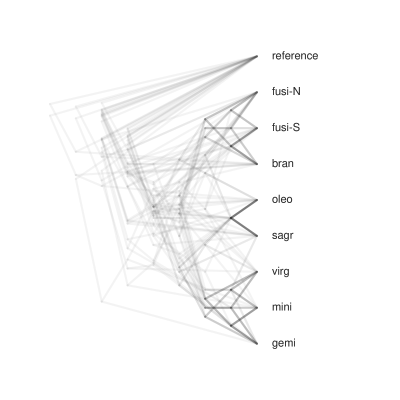

In [10]:
# filter to only windows with >50 SNPS (this could have been done in run)
trees = ts.tree_table[ts.tree_table.snps > 50].tree.tolist()

# load all trees into a multitree object
mtre = toytree.mtree(trees)

# root trees 
mtre.treelist = [i.root("reference") for i in mtre.treelist]

# infer a consensus tree to get best tip order
ctre = mtre.get_consensus_tree()

# draw the first 12 trees in a grid
mtre.draw_cloud_tree(
    width=400,
    height=400, 
    fixed_order=ctre.get_tip_labels(),
    use_edge_lengths=False,
);

<h3><span style="color:red">Advanced</span>: Modify the raxml command</h3>

In this analysis I entered multiple scaffolds to create windows across each scaffold. I also entered a smaller slide size than window size so that windows are partially overlapping. The raxml command string was modified to perform 10 full searches with no bootstraps. 

In [11]:
# select a scaffold idx, start, and end positions
ts = ipa.treeslider(
    name="chr1_w500K_s100K",
    data=data,
    workdir="analysis-treeslider",
    scaffold_idxs=[0, 1, 2],
    window_size=500000,
    slide_size=100000,
    minsnps=10,
    inference_method="raxml",
    inference_args={"m": "GTRCAT", "N": 10, "f": "d", 'x': None},
)

In [12]:
# this is the tree inference command that will be used
ts.show_inference_command()

raxmlHPC-PTHREADS-SSE3 -f d -T 2 -m GTRCAT -n ... -w ... -s ... -p 54321 -N 10
